In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline


In [ ]:
#Constantes

g0 = 1*1e-3
u0 = np.pi*4*1e-7
W = 4*1e-2
D = 3.5*1e-2
d = 8*1e-3
N1 = 1000


1000


### Considere inicialmente que não há corrente na bobina.
### Apresente um gráfico para a força magnética que surge no elemento
móvel nas condições a seguir:   
•Considerando uma aproximação linear da forma:  
$$
B_{\mathrm{m}} = \mu_{\mathrm{R}} (H_{\mathrm{m}} - H_{\mathrm{c}}^{\prime})
$$
•Considerando a curva BxH fornecida para o imã.


0.0230872572890346


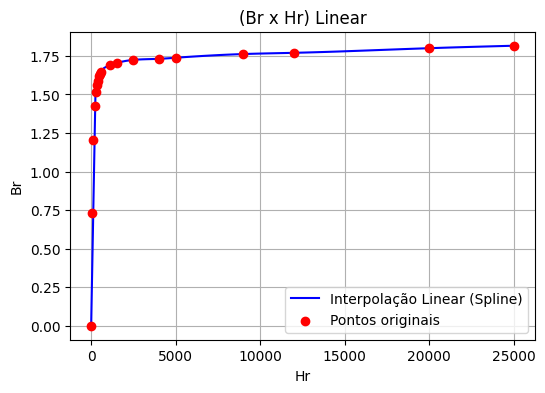

In [ ]:
#desse modo como não possuimos todos os parâmetros utilizamos interporlação cúbica

Br = np.array([0, 1.2])
Hr = np.array([-52000, 0])

# Criar a função linear via spline natural
funcao_linear = CubicSpline(Hr, Br, bc_type='natural')

# Gerar vários pontos no intervalo para plotar a reta
x_vals = np.linspace(Hr.min(), Hr.max(), 100)
y_vals = funcao_linear(x_vals)

# Plot
plt.figure(figsize=(6, 4))
plt.plot(x_vals, y_vals, label="Interpolação Linear (Spline)", color="blue")  # reta
plt.scatter(Hr, Br, color="red", zorder=5, label="Pontos originais")          # pontos dados
plt.xlabel("Hr")
plt.ylabel("Br")
plt.title("(Br x Hr) Linear")
plt.grid(True)
plt.legend()
plt.show()



Já para 